## Task 1: Environment Creation 

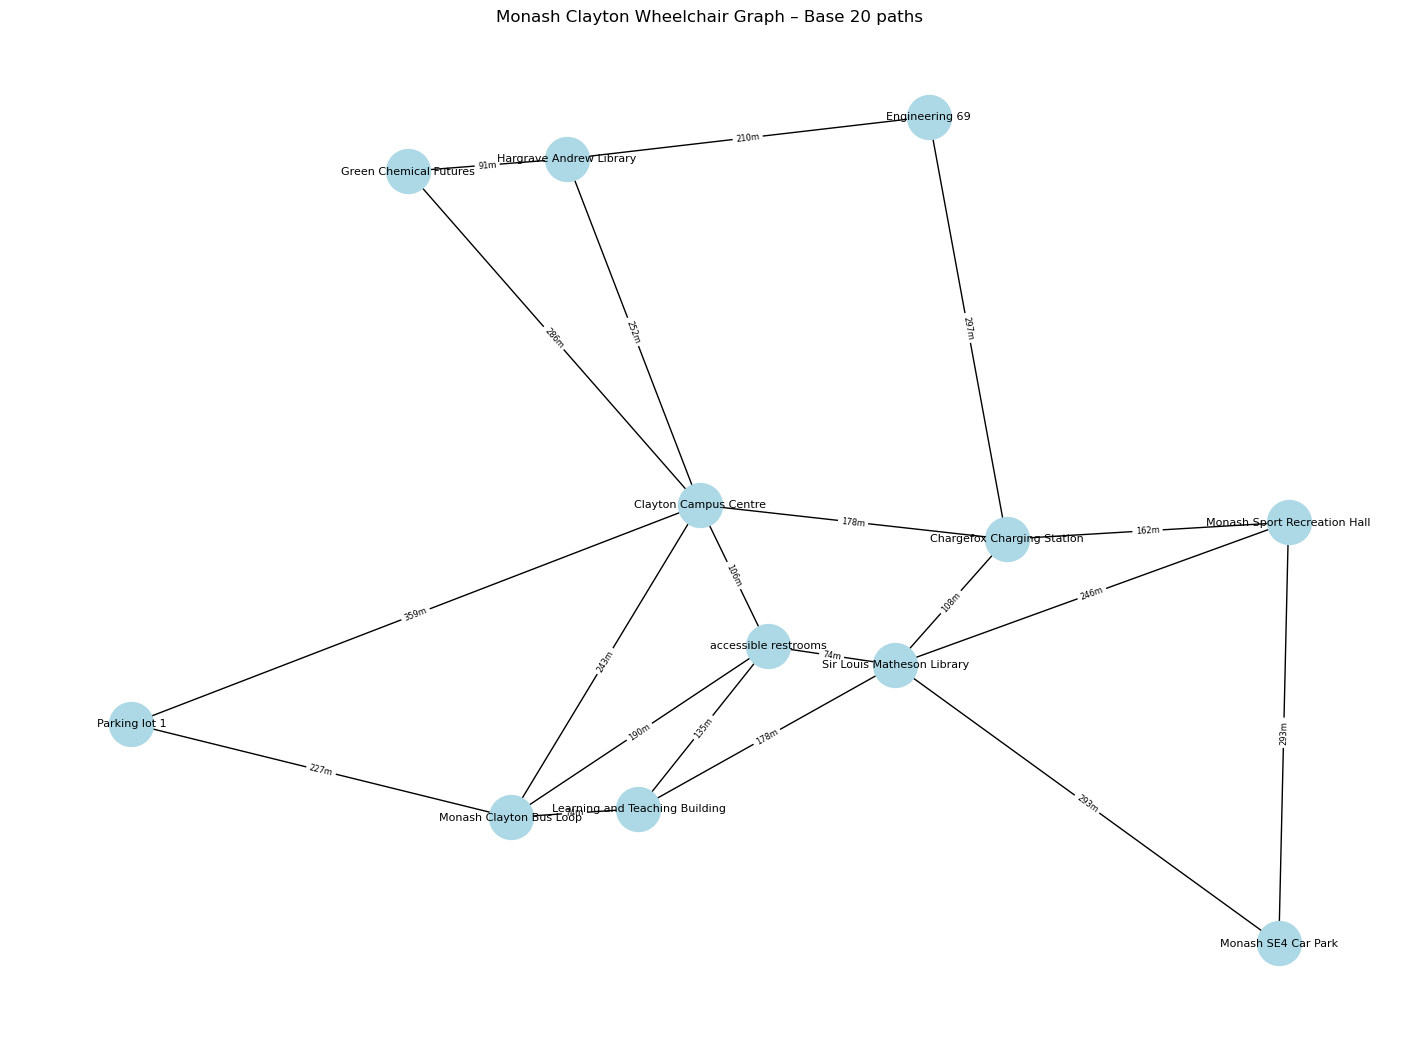

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from math import radians, cos, sin, asin, sqrt

# Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000
    dlat, dlon = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return round(R * 2 * asin(sqrt(a)))

# Node coordinates
nodes = {
    'Clayton Campus Centre': (-37.911985, 145.1329755),
    'Sir Louis Matheson Library': (-37.9129856, 145.1342535),
    'Learning and Teaching Building': (-37.91388469999999, 145.132576),
    'Engineering 69': (-37.9095578, 145.1344738),
    'Monash Sport Recreation Hall': (-37.9120934, 145.1368239),
    'Chargefox Charging Station': (-37.912199, 145.1349814),
    'Monash Clayton Bus Loop': (-37.9139385, 145.1317406),
    'Hargrave Andrew Library': (-37.9098209, 145.1321059),
    'Green Chemical Futures': (-37.909899, 145.1310694),
    'Parking lot 1': (-37.91335309999999, 145.1292633),
    'accessible restrooms': (-37.9128677, 145.1334228),
    'Monash SE4 Car Park': (-37.9147256, 145.1367609)
}

# Base 20 segments
base_segments = [
    ('Clayton Campus Centre', 'accessible restrooms'),
    ('Clayton Campus Centre', 'Monash Clayton Bus Loop'),
    ('Clayton Campus Centre', 'Parking lot 1'),
    ('Clayton Campus Centre', 'Green Chemical Futures'),
    ('Clayton Campus Centre', 'Chargefox Charging Station'),
    ('Clayton Campus Centre', 'Hargrave Andrew Library'),
    ('Sir Louis Matheson Library', 'accessible restrooms'),
    ('Sir Louis Matheson Library', 'Chargefox Charging Station'),
    ('Sir Louis Matheson Library', 'Monash SE4 Car Park'),
    ('Sir Louis Matheson Library', 'Learning and Teaching Building'),
    ('Parking lot 1', 'Monash Clayton Bus Loop'),
    ('Learning and Teaching Building', 'accessible restrooms'),
    ('Engineering 69', 'Chargefox Charging Station'),
    ('Engineering 69', 'Hargrave Andrew Library'),
    ('Monash Sport Recreation Hall', 'Monash SE4 Car Park'),
    ('Monash Sport Recreation Hall', 'Chargefox Charging Station'),
    ('Monash Sport Recreation Hall', 'Sir Louis Matheson Library'),
    ('Hargrave Andrew Library', 'Green Chemical Futures'),
    ('Monash Clayton Bus Loop', 'Learning and Teaching Building'),
    ('Monash Clayton Bus Loop', 'accessible restrooms')
]
# Create initial graph
G = nx.Graph()
for name, (lat, lon) in nodes.items():
    G.add_node(name, lat=lat, lon=lon, pos=(lon, lat))

for u, v in base_segments:
    lat1, lon1 = G.nodes[u]['lat'], G.nodes[u]['lon']
    lat2, lon2 = G.nodes[v]['lat'], G.nodes[v]['lon']
    dist = haversine(lat1, lon1, lat2, lon2)
    G.add_edge(u, v, weight=dist)

# Visualize
positions = {name: G.nodes[name]['pos'] for name in G.nodes}
plt.figure(figsize=(14, 10))
nx.draw(G, positions, with_labels=True, node_color='lightblue', node_size=1000, font_size=8)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, positions, edge_labels={(u, v): f"{d:.0f}m" for (u, v), d in edge_labels.items()}, font_size=6)
plt.title("Monash Clayton Wheelchair Graph – Base 20 paths")
plt.axis("off")
plt.show()

## Task 2: Basic navigation implementation

### Task 2.1a: Adjency matrix of enviroment

In [2]:
from queue import PriorityQueue
adj_matrix_G = round(nx.to_pandas_adjacency(G, weight="weight"))
display(adj_matrix_G)  

,Clayton Campus Centre,Sir Louis Matheson Library,Learning and Teaching Building,Engineering 69,Monash Sport Recreation Hall,Chargefox Charging Station,Monash Clayton Bus Loop,Hargrave Andrew Library,Green Chemical Futures,Parking lot 1,accessible restrooms,Monash SE4 Car Park
Clayton Campus Centre,0.0,0.0,0.0,0.0,0.0,178.0,243.0,252.0,286.0,359.0,106.0,0.0
Sir Louis Matheson Library,0.0,0.0,178.0,0.0,246.0,108.0,0.0,0.0,0.0,0.0,74.0,293.0
Learning and Teaching Building,0.0,178.0,0.0,0.0,0.0,0.0,74.0,0.0,0.0,0.0,135.0,0.0
Engineering 69,0.0,0.0,0.0,0.0,0.0,297.0,0.0,210.0,0.0,0.0,0.0,0.0
Monash Sport Recreation Hall,0.0,246.0,0.0,0.0,0.0,162.0,0.0,0.0,0.0,0.0,0.0,293.0
Chargefox Charging Station,178.0,108.0,0.0,297.0,162.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Monash Clayton Bus Loop,243.0,0.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,227.0,190.0,0.0
Hargrave Andrew Library,252.0,0.0,0.0,210.0,0.0,0.0,0.0,0.0,91.0,0.0,0.0,0.0
Green Chemical Futures,286.0,0.0,0.0,0.0,0.0,0.0,0.0,91.0,0.0,0.0,0.0,0.0
Parking lot 1,359.0,0.0,0.0,0.0,0.0,0.0,227.0,0.0,0.0,0.0,0.0,0.0


### Task 2.1b: implementation of A* Search

In [3]:
# A* search function
def astar_search(graph, start, goal, heuristic_func):
    frontier = PriorityQueue()
    frontier.put((0, start))
    came_from = {start: None}
    cost_so_far = {start: 0}
    expanded_nodes = 0

    while not frontier.empty():
        _, current = frontier.get()
        expanded_nodes += 1

        if current == goal:
            break

        for neighbor in graph.neighbors(current):
            new_cost = cost_so_far[current] + graph[current][neighbor]['weight']
            if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                cost_so_far[neighbor] = new_cost
                priority = new_cost + heuristic_func(graph, neighbor, goal)
                frontier.put((priority, neighbor))
                came_from[neighbor] = current

    # Reconstruct path
    if goal not in came_from:
        return None, float('inf'), expanded_nodes

    path = []
    node = goal
    while node != start:
        path.append(node)
        node = came_from[node]
    path.append(start)
    path.reverse()

    return path, cost_so_far[goal], expanded_nodes

### Task 2.2: Testing the A* algorithm implementation

In [4]:
tests_for_task2 = [
    ('Engineering 69', 'Sir Louis Matheson Library'),
    ('Monash Sport Recreation Hall', 'Green Chemical Futures'),
    ('Parking lot 1', 'accessible restrooms'),
    ('Learning and Teaching Building', 'Monash SE4 Car Park')
]

print("===  A* Tests  ===")
for start, goal in tests_for_task2:
    path, cost, expanded = astar_search(
        G,
        start,
        goal,
        lambda G, n1, n2: haversine(G.nodes[n1]['lat'], G.nodes[n1]['lon'], G.nodes[n2]['lat'], G.nodes[n2]['lon'])
    )

    
    print(f"{start} → {goal}")
    print("Path:", " → ".join(path))
    print("Total Cost:", round(cost))
    print("Nodes Expanded:", expanded)
    print()

===  A* Tests  ===
Engineering 69 → Sir Louis Matheson Library
Path: Engineering 69 → Chargefox Charging Station → Sir Louis Matheson Library
Total Cost: 405
Nodes Expanded: 3

Monash Sport Recreation Hall → Green Chemical Futures
Path: Monash Sport Recreation Hall → Chargefox Charging Station → Clayton Campus Centre → Green Chemical Futures
Total Cost: 626
Nodes Expanded: 4

Parking lot 1 → accessible restrooms
Path: Parking lot 1 → Monash Clayton Bus Loop → accessible restrooms
Total Cost: 417
Nodes Expanded: 3

Learning and Teaching Building → Monash SE4 Car Park
Path: Learning and Teaching Building → Sir Louis Matheson Library → Monash SE4 Car Park
Total Cost: 471
Nodes Expanded: 3



## Task 3: Enhance environment and heuristics comparison 

 ### Task 3.1: Adding extra path segments 

In [5]:
# Extra 11 segments
extra_segments = [
    ('Engineering 69', 'Green Chemical Futures'),
    ('Monash SE4 Car Park', 'Learning and Teaching Building'),
    ('Monash SE4 Car Park', 'Parking lot 1'),
    ('Hargrave Andrew Library', 'accessible restrooms'),
    ('Chargefox Charging Station', 'Green Chemical Futures'),
    ('Sir Louis Matheson Library', 'Hargrave Andrew Library'),
    ('Engineering 69', 'Monash SE4 Car Park'),
    ('Parking lot 1', 'Learning and Teaching Building'),
    ('Chargefox Charging Station', 'Parking lot 1'),
    ('Green Chemical Futures', 'Parking lot 1'),
    ('Hargrave Andrew Library', 'Monash Clayton Bus Loop')
]

# Create graph
G_expanded = nx.Graph()
for name, (lat, lon) in nodes.items():
    G_expanded.add_node(name, lat=lat, lon=lon, pos=(lon, lat))

### Task 3.2: Adding environmental constraints

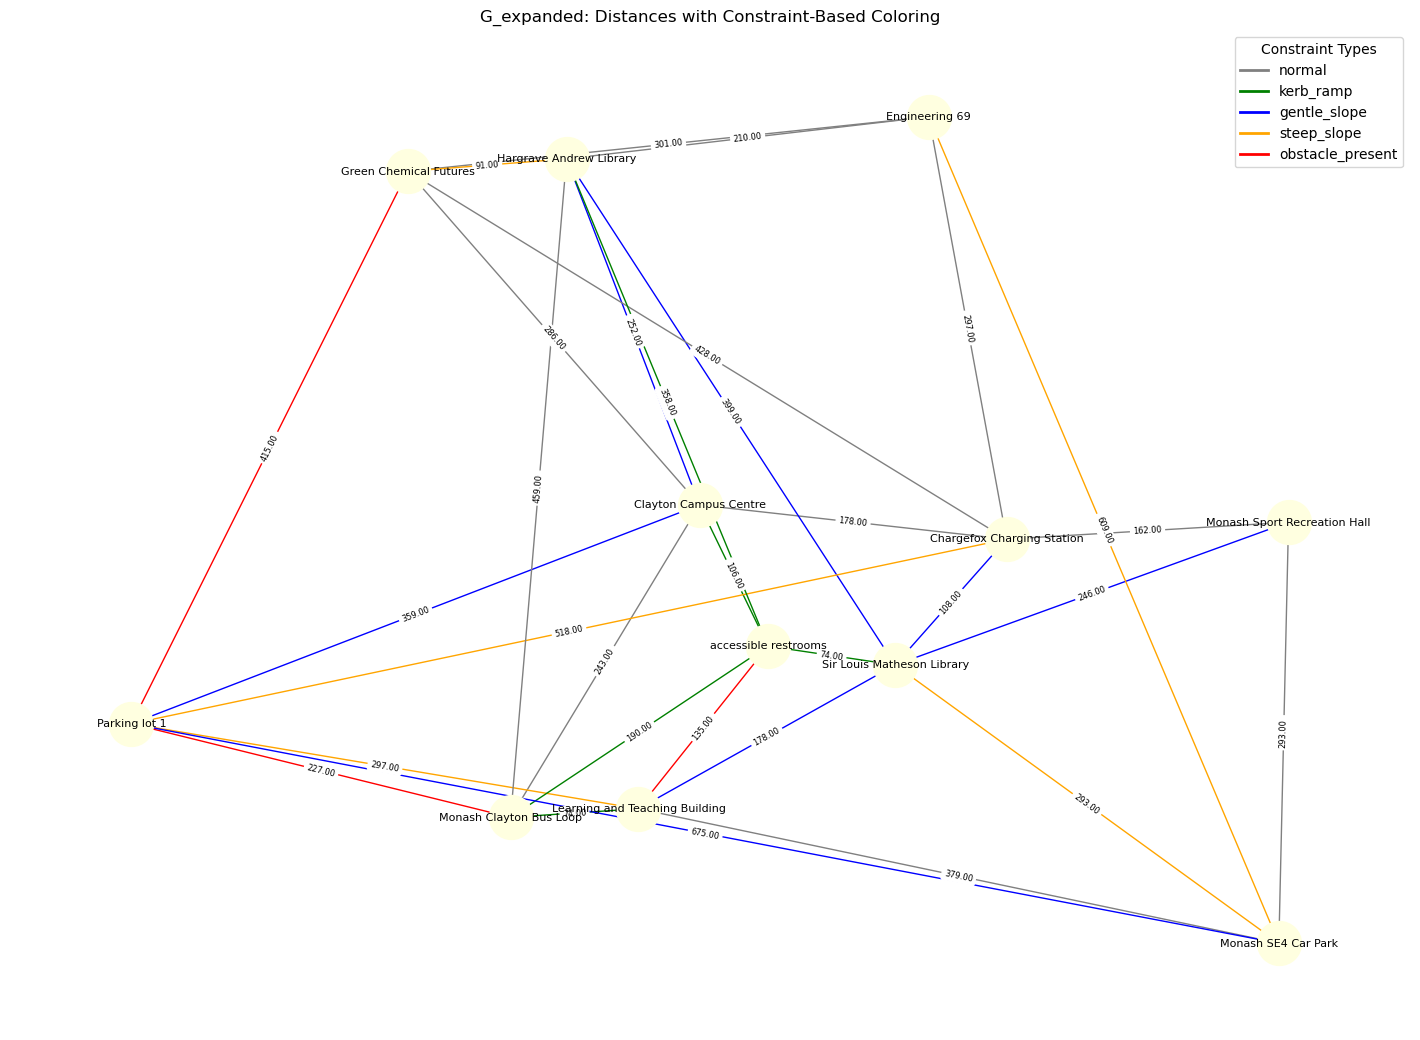

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D

# Step 1: Add weighted edges to G_expanded using haversine
for u, v in base_segments + extra_segments:
    lat1, lon1 = G_expanded.nodes[u]['lat'], G_expanded.nodes[u]['lon']
    lat2, lon2 = G_expanded.nodes[v]['lat'], G_expanded.nodes[v]['lon']
    dist = haversine(lat1, lon1, lat2, lon2)
    G_expanded.add_edge(u, v, weight=dist)

# Step 2: Define constraint colors and assign constraints to edges
constraint_colors = {
    "normal": "gray",
    "kerb_ramp": "green",
    "gentle_slope": "blue",
    "steep_slope": "orange",
    "obstacle_present": "red"
}

fixed_constraints = {
    ('Clayton Campus Centre', 'accessible restrooms'): 'kerb_ramp',
    ('Clayton Campus Centre', 'Monash Clayton Bus Loop'): 'normal',
    ('Clayton Campus Centre', 'Parking lot 1'): 'gentle_slope',
    ('Clayton Campus Centre', 'Green Chemical Futures'): 'normal',
    ('Clayton Campus Centre', 'Chargefox Charging Station'): 'normal',
    ('Clayton Campus Centre', 'Hargrave Andrew Library'): 'gentle_slope',
    ('Sir Louis Matheson Library', 'accessible restrooms'): 'kerb_ramp',
    ('Sir Louis Matheson Library', 'Chargefox Charging Station'): 'gentle_slope',
    ('Sir Louis Matheson Library', 'Monash SE4 Car Park'): 'steep_slope',
    ('Sir Louis Matheson Library', 'Learning and Teaching Building'): 'gentle_slope',
    ('Parking lot 1', 'Monash Clayton Bus Loop'): 'obstacle_present',
    ('Learning and Teaching Building', 'accessible restrooms'): 'obstacle_present',
    ('Engineering 69', 'Chargefox Charging Station'): 'normal',
    ('Engineering 69', 'Hargrave Andrew Library'): 'normal',
    ('Monash Sport Recreation Hall', 'Monash SE4 Car Park'): 'normal',
    ('Monash Sport Recreation Hall', 'Chargefox Charging Station'): 'normal',
    ('Monash Sport Recreation Hall', 'Sir Louis Matheson Library'): 'gentle_slope',
    ('Hargrave Andrew Library', 'Green Chemical Futures'): 'steep_slope',
    ('Monash Clayton Bus Loop', 'Learning and Teaching Building'): 'kerb_ramp',
    ('Monash Clayton Bus Loop', 'accessible restrooms'): 'kerb_ramp',
    ('Engineering 69', 'Green Chemical Futures'): 'normal',
    ('Monash SE4 Car Park', 'Learning and Teaching Building'): 'normal',
    ('Monash SE4 Car Park', 'Parking lot 1'): 'gentle_slope',
    ('Hargrave Andrew Library', 'accessible restrooms'): 'kerb_ramp',
    ('Chargefox Charging Station', 'Green Chemical Futures'): 'normal',
    ('Sir Louis Matheson Library', 'Hargrave Andrew Library'): 'gentle_slope',
    ('Engineering 69', 'Monash SE4 Car Park'): 'steep_slope',
    ('Parking lot 1', 'Learning and Teaching Building'): 'steep_slope',
    ('Chargefox Charging Station', 'Parking lot 1'): 'steep_slope',
    ('Green Chemical Futures', 'Parking lot 1'): 'obstacle_present',
    ('Hargrave Andrew Library', 'Monash Clayton Bus Loop'): 'normal'
}

# Assign constraints to edges
for u, v in G_expanded.edges():
    if (u, v) in fixed_constraints:
        G_expanded[u][v]['constraint'] = fixed_constraints[(u, v)]
    elif (v, u) in fixed_constraints:
        G_expanded[u][v]['constraint'] = fixed_constraints[(v, u)]
    else:
        G_expanded[u][v]['constraint'] = 'normal'

# Step 3: Plot with distance labels and constraint-based edge colors
edge_colors = [constraint_colors[G_expanded[u][v]['constraint']] for u, v in G_expanded.edges()]
edge_labels = {(u, v): f"{G_expanded[u][v]['weight']:.2f}" for u, v in G_expanded.edges()}

# Use predefined positions if available
positions = positions if 'positions' in locals() and positions else nx.spring_layout(G_expanded)

plt.figure(figsize=(14, 10))
nx.draw(G_expanded, pos=positions, with_labels=True,
        node_color='lightyellow', node_size=1000,
        font_size=8, edge_color=edge_colors)
nx.draw_networkx_edge_labels(G_expanded, pos=positions,
                             edge_labels=edge_labels, font_size=6)

# Add legend
legend_elements = [Line2D([0], [0], color=color, lw=2, label=label)
                   for label, color in constraint_colors.items()]
plt.legend(handles=legend_elements, loc='upper right', title="Constraint Types")

plt.title("G_expanded: Distances with Constraint-Based Coloring")
plt.axis("off")
plt.show()


### Task 3 (additionally added adjency matrix by me for better understanding)

In [7]:
import pandas as pd
nodes = list(G_expanded.nodes)

combined_matrix = pd.DataFrame('', index=nodes, columns=nodes)

for u, v, data in G_expanded.edges(data=True):
    weight = round(data.get('weight', 0))
    constraint = data.get('constraint', 'normal')
    entry = f"{weight:.2f} ({constraint})"
    
    combined_matrix.loc[u, v] = entry
    combined_matrix.loc[v, u] = entry

display(combined_matrix)

,Clayton Campus Centre,Sir Louis Matheson Library,Learning and Teaching Building,Engineering 69,Monash Sport Recreation Hall,Chargefox Charging Station,Monash Clayton Bus Loop,Hargrave Andrew Library,Green Chemical Futures,Parking lot 1,accessible restrooms,Monash SE4 Car Park
Clayton Campus Centre,,,,,,178.00 (normal),243.00 (normal),252.00 (gentle_slope),286.00 (normal),359.00 (gentle_slope),106.00 (kerb_ramp),
Sir Louis Matheson Library,,,178.00 (gentle_slope),,246.00 (gentle_slope),108.00 (gentle_slope),,399.00 (gentle_slope),,,74.00 (kerb_ramp),293.00 (steep_slope)
Learning and Teaching Building,,178.00 (gentle_slope),,,,,74.00 (kerb_ramp),,,297.00 (steep_slope),135.00 (obstacle_present),379.00 (normal)
Engineering 69,,,,,,297.00 (normal),,210.00 (normal),301.00 (normal),,,609.00 (steep_slope)
Monash Sport Recreation Hall,,246.00 (gentle_slope),,,,162.00 (normal),,,,,,293.00 (normal)
Chargefox Charging Station,178.00 (normal),108.00 (gentle_slope),,297.00 (normal),162.00 (normal),,,,428.00 (normal),518.00 (steep_slope),,
Monash Clayton Bus Loop,243.00 (normal),,74.00 (kerb_ramp),,,,,459.00 (normal),,227.00 (obstacle_present),190.00 (kerb_ramp),
Hargrave Andrew Library,252.00 (gentle_slope),399.00 (gentle_slope),,210.00 (normal),,,459.00 (normal),,91.00 (steep_slope),,358.00 (kerb_ramp),
Green Chemical Futures,286.00 (normal),,,301.00 (normal),,428.00 (normal),,91.00 (steep_slope),,415.00 (obstacle_present),,
Parking lot 1,359.00 (gentle_slope),,297.00 (steep_slope),,,518.00 (steep_slope),227.00 (obstacle_present),,415.00 (obstacle_present),,,675.00 (gentle_slope)


### Task 3.3: Heuristic with constraint Accessibility Awareness

In [8]:

def constraint_penalty(constraint):
    penalties = {
        "normal": 1.0,
        "kerb_ramp": 0.9,
        "gentle_slope": 1.5,
        "steep_slope": 2.5,
        "obstacle_present": 5.0
    }
    return penalties.get(constraint, 1.0)

def constraint_aware_heuristic(G, current, goal):
    lat1, lon1 = G.nodes[current]['lat'], G.nodes[current]['lon']
    lat2, lon2 = G.nodes[goal]['lat'], G.nodes[goal]['lon']
    base_distance = haversine(lat1, lon1, lat2, lon2)
    if G.has_edge(current, goal):
        constraint = G[current][goal].get('constraint', 'normal')
    else:
        constraint = 'normal'
    return base_distance * constraint_penalty(constraint)


### Task 3 Test: Comparison Basic vs Constraint-Aware Heuristic

In [9]:

# Define test cases
test_cases = [
    ('Clayton Campus Centre', 'Monash SE4 Car Park'),
    ('Parking lot 1', 'Sir Louis Matheson Library'),
    ('Green Chemical Futures', 'Monash SE4 Car Park'),
    ('Engineering 69', 'Learning and Teaching Building'),
    ('Hargrave Andrew Library', 'Monash SE4 Car Park')
]

# Run both heuristics
comparison_results_task3 = []

for start, goal in test_cases:
    basic_path, basic_cost, basic_expanded = astar_search(
        G_expanded, start, goal,
        lambda G, n1, n2: haversine(G.nodes[n1]['lat'], G.nodes[n1]['lon'], G.nodes[n2]['lat'], G.nodes[n2]['lon'])
    )

    constraint_path, constraint_cost, constraint_expanded = astar_search(
        G_expanded, start, goal, constraint_aware_heuristic
    )


    # Print comparison for each test case
    print(f"=== {start} → {goal} ===")
    print("Basic A* Path:", basic_path)
    print("Basic Cost:", basic_cost, "| Nodes Expanded:", basic_expanded)
    print("Constraint-Aware A* Path:", constraint_path)
    print("Constraint-Aware Cost:", constraint_cost, "| Nodes Expanded:", constraint_expanded)
    print()

    comparison_results_task3.append({
        "Start": start,
        "Goal": goal,
        "Basic Path": basic_path,
        "Basic Cost": basic_cost,
        "Basic Nodes Expanded": basic_expanded,
        "Constraint-Aware Path": constraint_path,
        "Constraint-Aware Cost": constraint_cost,
        "Constraint-Aware Nodes Expanded": constraint_expanded
    })

import pandas as pd
pd.DataFrame(comparison_results_task3)


=== Clayton Campus Centre → Monash SE4 Car Park ===
Basic A* Path: ['Clayton Campus Centre', 'accessible restrooms', 'Sir Louis Matheson Library', 'Monash SE4 Car Park']
Basic Cost: 473 | Nodes Expanded: 4
Constraint-Aware A* Path: ['Clayton Campus Centre', 'accessible restrooms', 'Learning and Teaching Building', 'Monash SE4 Car Park']
Constraint-Aware Cost: 620 | Nodes Expanded: 5

=== Parking lot 1 → Sir Louis Matheson Library ===
Basic A* Path: ['Parking lot 1', 'Learning and Teaching Building', 'Sir Louis Matheson Library']
Basic Cost: 475 | Nodes Expanded: 4
Constraint-Aware A* Path: ['Parking lot 1', 'Monash Clayton Bus Loop', 'accessible restrooms', 'Sir Louis Matheson Library']
Constraint-Aware Cost: 491 | Nodes Expanded: 4

=== Green Chemical Futures → Monash SE4 Car Park ===
Basic A* Path: ['Green Chemical Futures', 'Clayton Campus Centre', 'accessible restrooms', 'Sir Louis Matheson Library', 'Monash SE4 Car Park']
Basic Cost: 759 | Nodes Expanded: 6
Constraint-Aware A* Pat

,Start,Goal,Basic Path,Basic Cost,Basic Nodes Expanded,Constraint-Aware Path,Constraint-Aware Cost,Constraint-Aware Nodes Expanded
0,Clayton Campus Centre,Monash SE4 Car Park,"[Clayton Campus Centre, accessible restrooms, ...",473,4,"[Clayton Campus Centre, accessible restrooms, ...",620,5
1,Parking lot 1,Sir Louis Matheson Library,"[Parking lot 1, Learning and Teaching Building...",475,4,"[Parking lot 1, Monash Clayton Bus Loop, acces...",491,4
2,Green Chemical Futures,Monash SE4 Car Park,"[Green Chemical Futures, Clayton Campus Centre...",759,6,"[Green Chemical Futures, Chargefox Charging St...",883,7
3,Engineering 69,Learning and Teaching Building,"[Engineering 69, Chargefox Charging Station, S...",583,4,"[Engineering 69, Chargefox Charging Station, S...",583,5
4,Hargrave Andrew Library,Monash SE4 Car Park,"[Hargrave Andrew Library, Sir Louis Matheson L...",692,3,"[Hargrave Andrew Library, accessible restrooms...",872,7


## Task 4: Performance enhancement with an alternative algorithm

### Task 4.1: implementation of dijkstra search algorithm

In [10]:

def dijkstra_search(graph, start, goal):
    from queue import PriorityQueue
    frontier = PriorityQueue()
    frontier.put((0, start))
    came_from = {start: None}
    cost_so_far = {start: 0}
    expanded_nodes = 0

    while not frontier.empty():
        _, current = frontier.get()
        expanded_nodes += 1

        if current == goal:
            break

        for neighbor in graph.neighbors(current):
            new_cost = cost_so_far[current] + graph[current][neighbor]['weight']
            if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                cost_so_far[neighbor] = new_cost
                frontier.put((new_cost, neighbor))
                came_from[neighbor] = current

    if goal not in came_from:
        return None, float('inf'), expanded_nodes

    path = []
    node = goal
    while node != start:
        path.append(node)
        node = came_from[node]
    path.append(start)
    path.reverse()

    return path, cost_so_far[goal], expanded_nodes


### Task 4 Test: Comparison between A* and dijkstra search algorithm implementation

In [11]:

# Define test cases for comparison
test_cases = [
    ('Clayton Campus Centre', 'Monash SE4 Car Park'),
    ('Parking lot 1', 'Sir Louis Matheson Library'),
    ('Green Chemical Futures', 'Monash SE4 Car Park'),
    ('Engineering 69', 'Learning and Teaching Building'),
    ('Hargrave Andrew Library', 'Monash SE4 Car Park')
]

# Run Dijkstra vs A* with constraint-aware heuristic
comparison_results_task4 = []

def format_path(path_list):
    return " → ".join(path_list) if path_list else "No path"

for start, goal in test_cases:
    dijkstra_path, dijkstra_cost, dijkstra_expanded = dijkstra_search(G_expanded, start, goal)
    constraint_path, constraint_cost, constraint_expanded = astar_search(G_expanded, start, goal, constraint_aware_heuristic)

    print(f"=== {start} → {goal} ===")
    print("Dijkstra Path:", dijkstra_path)
    print("Dijkstra Cost:", dijkstra_cost, "| Nodes Expanded:", dijkstra_expanded)
    print("A* Constraint-Aware Path:", constraint_path)
    print("A* Cost:", constraint_cost, "| Nodes Expanded:", constraint_expanded)
    print()

    comparison_results_task4.append({
        "Start": start,
        "Goal": goal,
        "Dijkstra Path": format_path(dijkstra_path),
        "Dijkstra Cost": dijkstra_cost,
        "Dijkstra Nodes Expanded": dijkstra_expanded,
        "A* Path": format_path(constraint_path),
        "A* Cost": constraint_cost,
        "A* Nodes Expanded": constraint_expanded
    })


pd.DataFrame(comparison_results_task4)


=== Clayton Campus Centre → Monash SE4 Car Park ===
Dijkstra Path: ['Clayton Campus Centre', 'accessible restrooms', 'Sir Louis Matheson Library', 'Monash SE4 Car Park']
Dijkstra Cost: 473 | Nodes Expanded: 12
A* Constraint-Aware Path: ['Clayton Campus Centre', 'accessible restrooms', 'Learning and Teaching Building', 'Monash SE4 Car Park']
A* Cost: 620 | Nodes Expanded: 5

=== Parking lot 1 → Sir Louis Matheson Library ===
Dijkstra Path: ['Parking lot 1', 'Learning and Teaching Building', 'Sir Louis Matheson Library']
Dijkstra Cost: 475 | Nodes Expanded: 7
A* Constraint-Aware Path: ['Parking lot 1', 'Monash Clayton Bus Loop', 'accessible restrooms', 'Sir Louis Matheson Library']
A* Cost: 491 | Nodes Expanded: 4

=== Green Chemical Futures → Monash SE4 Car Park ===
Dijkstra Path: ['Green Chemical Futures', 'Clayton Campus Centre', 'accessible restrooms', 'Sir Louis Matheson Library', 'Monash SE4 Car Park']
Dijkstra Cost: 759 | Nodes Expanded: 15
A* Constraint-Aware Path: ['Green Chemic

,Start,Goal,Dijkstra Path,Dijkstra Cost,Dijkstra Nodes Expanded,A* Path,A* Cost,A* Nodes Expanded
0,Clayton Campus Centre,Monash SE4 Car Park,Clayton Campus Centre → accessible restrooms →...,473,12,Clayton Campus Centre → accessible restrooms →...,620,5
1,Parking lot 1,Sir Louis Matheson Library,Parking lot 1 → Learning and Teaching Building...,475,7,Parking lot 1 → Monash Clayton Bus Loop → acce...,491,4
2,Green Chemical Futures,Monash SE4 Car Park,Green Chemical Futures → Clayton Campus Centre...,759,15,Green Chemical Futures → Chargefox Charging St...,883,7
3,Engineering 69,Learning and Teaching Building,Engineering 69 → Chargefox Charging Station → ...,583,10,Engineering 69 → Chargefox Charging Station → ...,583,5
4,Hargrave Andrew Library,Monash SE4 Car Park,Hargrave Andrew Library → Sir Louis Matheson L...,692,15,Hargrave Andrew Library → accessible restrooms...,872,7


In [12]:

import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Dropdowns to select start and end
start_node = widgets.Dropdown(options=list(G_expanded.nodes), description="Start:")
end_node = widgets.Dropdown(options=list(G_expanded.nodes), description="End:")

# Dropdown to choose heuristic mode
heuristic_mode = widgets.ToggleButtons(
    options=[("Shortest path", "standard"), ("Convinient path", "constraint")],
    description="Heuristic:",
    button_style='info'
)

output_box = widgets.Output()

def constraint_penalty(constraint):
    penalties = {
        "normal": 1.0,
        "kerb_ramp": 0.9,
        "gentle_slope": 1.5,
        "steep_slope": 2.5,
        "obstacle_present": 5.0
    }
    return penalties.get(constraint, 1.0)

def constraint_aware_heuristic(G, current, goal):
    lat1, lon1 = G.nodes[current]['lat'], G.nodes[current]['lon']
    lat2, lon2 = G.nodes[goal]['lat'], G.nodes[goal]['lon']
    base_distance = haversine(lat1, lon1, lat2, lon2)
    if G.has_edge(current, goal):
        constraint = G[current][goal].get('constraint', 'normal')
    else:
        constraint = 'normal'
    return base_distance * constraint_penalty(constraint)

# Standard haversine heuristic
def standard_heuristic(graph, node1, node2):
    return haversine(graph.nodes[node1]['lat'], graph.nodes[node1]['lon'],
                     graph.nodes[node2]['lat'], graph.nodes[node2]['lon'])

# Button callback
def run_astar_gui(_):
    with output_box:
        clear_output()
        start, end = start_node.value, end_node.value
        mode = heuristic_mode.value

        if start == end:
            print("Start and End must be different.")
            return

        heuristic_fn = constraint_aware_heuristic if mode == "constraint" else standard_heuristic
        path, cost, expanded = astar_search(G_expanded, start, end, heuristic_fn)

        if not path:
            print("No path found.")
            return

        est_time = round(cost / 67)  # Assume 67m/min wheelchair speed
        pos = {n: G_expanded.nodes[n]['pos'] for n in G_expanded.nodes}
        edge_labels = {(u, v): f"{G_expanded[u][v]['weight']:.0f}m" for u, v in G_expanded.edges()}
        edge_path = list(zip(path[:-1], path[1:]))

        # Plot graph and path
        plt.figure(figsize=(12, 8))
        nx.draw(G_expanded, pos, with_labels=True, node_size=800, node_color='lightyellow', font_size=8)
        nx.draw_networkx_edges(G_expanded, pos, edgelist=edge_path, width=4, edge_color='red')
        nx.draw_networkx_edge_labels(G_expanded, pos, edge_labels=edge_labels, font_size=6)
        plt.title(f"{start} to {end} ({'Most Convinient' if mode == 'constraint' else 'Shortest path'})")
        plt.axis("off")
        plt.show()

        print(f"Path: {' → '.join(path)}")
        print(f"Total Distance: {cost:.2f} meters")
        print(f"Estimated Travel Time: {est_time} minutes")
        print(f"Nodes Expanded: {expanded}")

        if mode == "constraint":
            print("\nPath Constraints:")
            for u, v in edge_path:
                constraint = G_expanded[u][v].get("constraint", "normal")
                print(f"  {u} → {v}: {constraint}")

# Button to trigger A* run
run_button = widgets.Button(description="Calculate Path", button_style="primary")
run_button.on_click(run_astar_gui)

# Display all widgets
display(widgets.VBox([start_node, end_node, heuristic_mode, run_button, output_box]))
